In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


In [18]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/329/data.csv')
df.head()

,quality,pre_screening,ma1,ma2,ma3,ma4,ma5,ma6,exudate1,exudate2,exudate3,exudate3.1,exudate5,exudate6,exudate7,exudate8,macula_opticdisc_distance,opticdisc_diameter,am_fm_classification,Class
0,1,1,22,22,22,19,18,14,49.895756,17.775994,5.270920,0.771761,0.018632,0.006864,0.003923,0.003923,0.486903,0.100025,1,0
1,1,1,24,24,22,18,16,13,57.709936,23.799994,3.325423,0.234185,0.003903,0.003903,0.003903,0.003903,0.520908,0.144414,0,0
2,1,1,62,60,59,54,47,33,55.831441,27.993933,12.687485,4.852282,1.393889,0.373252,0.041817,0.007744,0.530904,0.128548,0,1
3,1,1,55,53,53,50,43,31,40.467228,18.445954,9.118901,3.079428,0.840261,0.272434,0.007653,0.001531,0.483284,0.114790,0,0
4,1,1,44,44,44,41,39,27,18.026254,8.570709,0.410381,0.000000,0.000000,0.000000,0.000000,0.000000,0.475935,0.123572,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quality                    1151 non-null   int64  
 1   pre_screening              1151 non-null   int64  
 2   ma1                        1151 non-null   int64  
 3   ma2                        1151 non-null   int64  
 4   ma3                        1151 non-null   int64  
 5   ma4                        1151 non-null   int64  
 6   ma5                        1151 non-null   int64  
 7   ma6                        1151 non-null   int64  
 8   exudate1                   1151 non-null   float64
 9   exudate2                   1151 non-null   float64
 10  exudate3                   1151 non-null   float64
 11  exudate3.1                 1151 non-null   float64
 12  exudate5                   1151 non-null   float64
 13  exudate6                   1151 non-null   float

In [4]:
df['Class'].value_counts()

Class
1    611
0    540
Name: count, dtype: int64

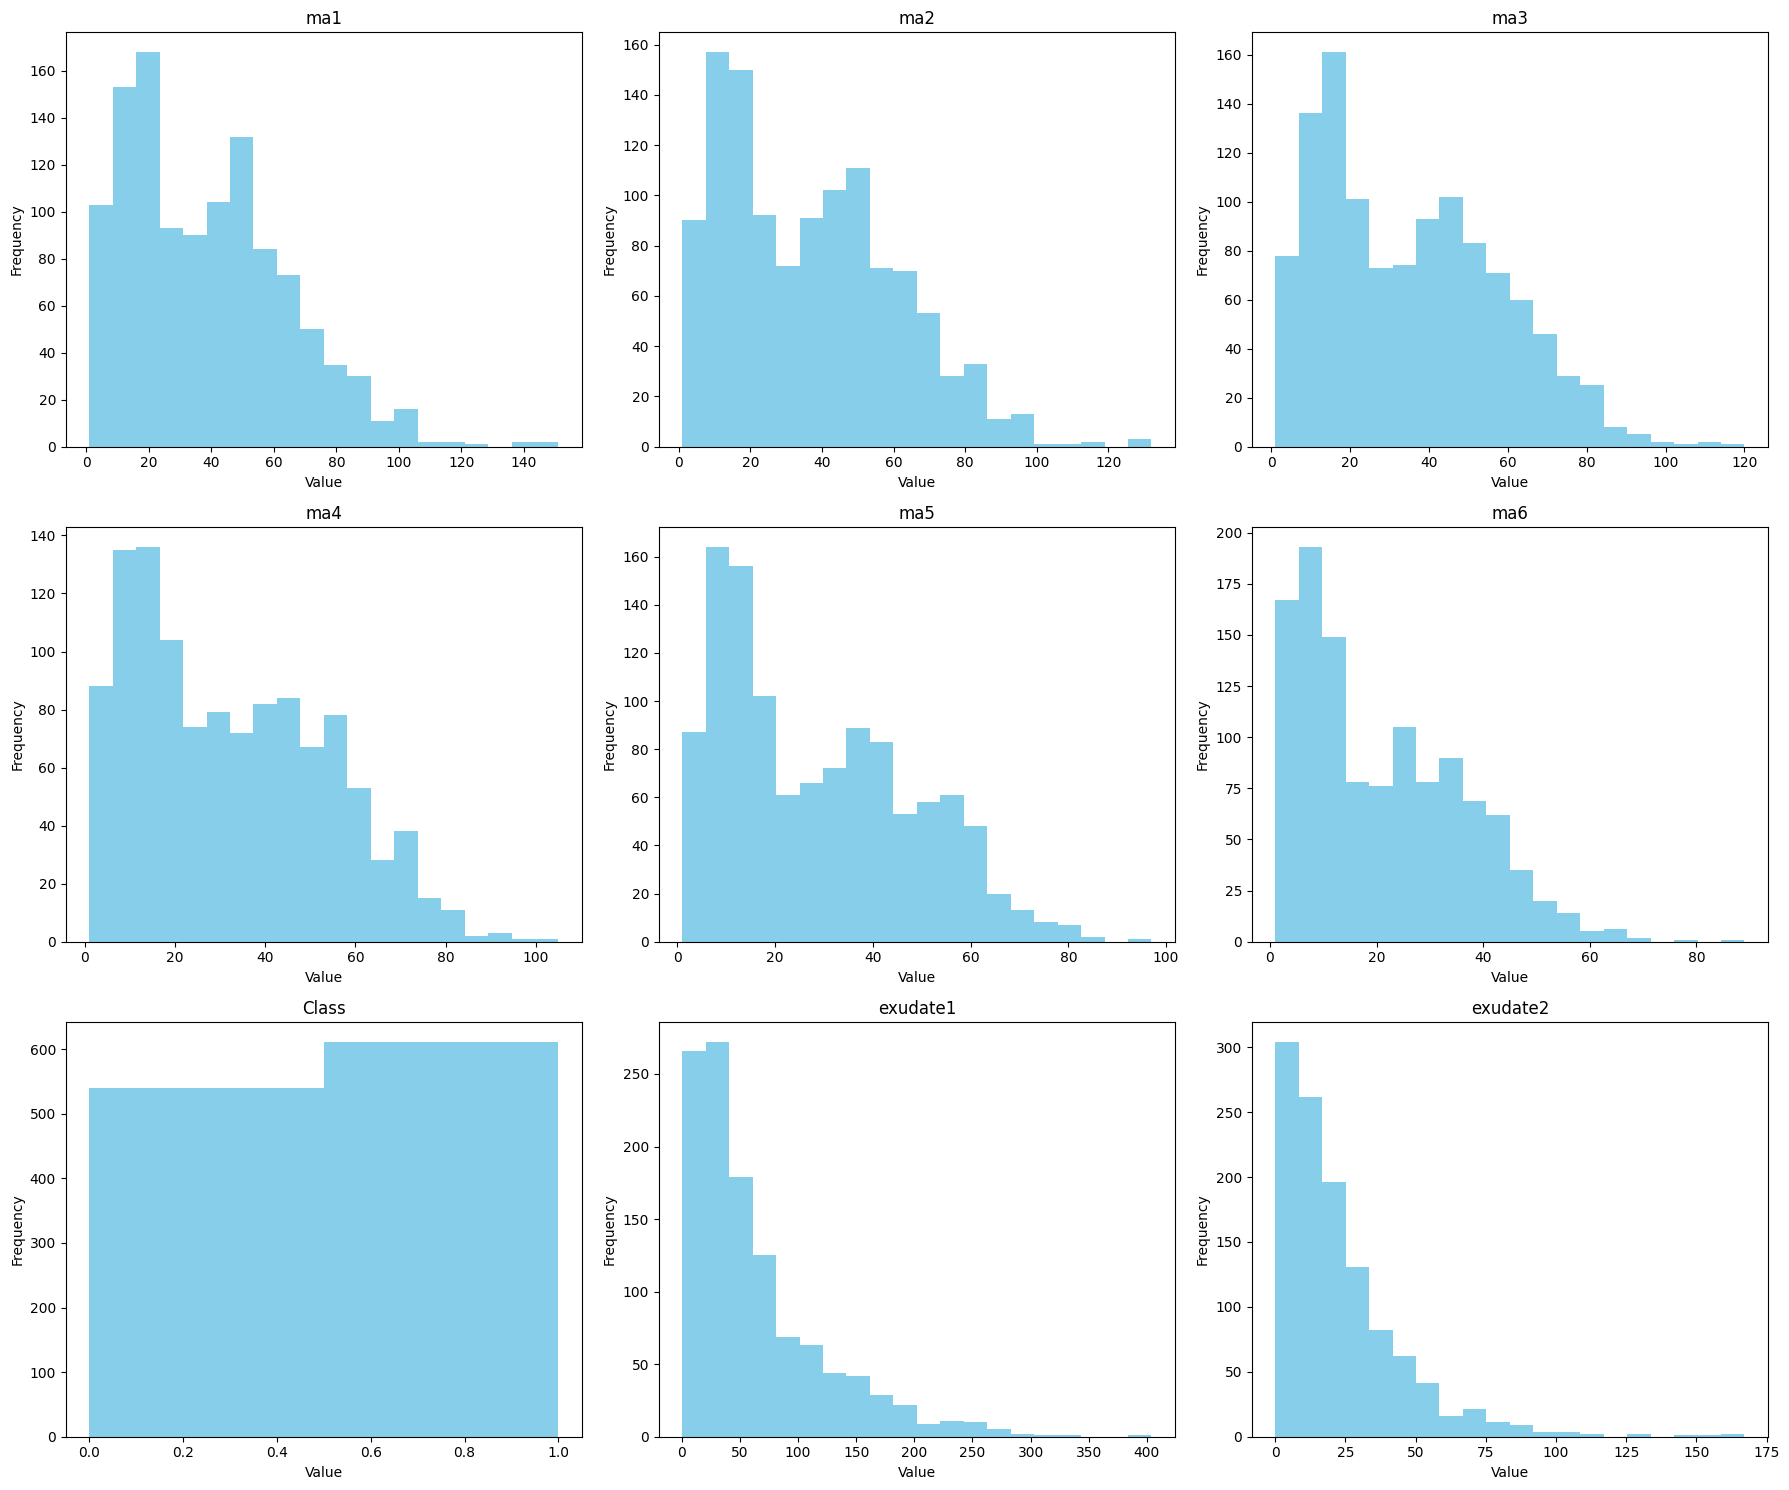

In [5]:
# Histogram

# Setting up the plotting area
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Titles for each subplot
titles = ['ma1', 'ma2', 'ma3', 'ma4', 'ma5', 'ma6', 'Class',
          'exudate1', 'exudate2', 'exudate3', 'exudate3.1', 'exudate5',
          'exudate6', 'exudate7', 'exudate8']

# Selecting the columns for the first 8 histograms
titles = ['ma1', 'ma2', 'ma3', 'ma4', 'ma5', 'ma6', 'Class',
          'exudate1', 'exudate2', 'exudate3', 'exudate3.1', 'exudate5',
          'exudate6', 'exudate7', 'exudate8']

# Plotting histograms for all specified features
for ax, title in zip(axes.flatten(), titles):
    # Special handling for the 'Class' column to use 2 bins
    if title == 'Class':
        ax.hist(df[title], bins=2, color='skyblue')
    else:
        ax.hist(df[title], bins=20, color='skyblue')  # Default 20 bins for others
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


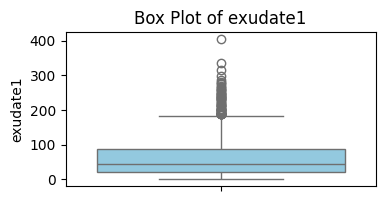

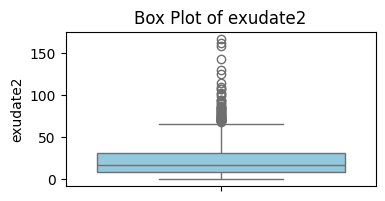

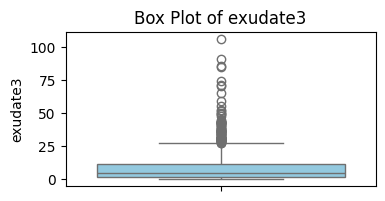

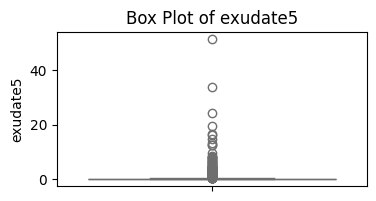

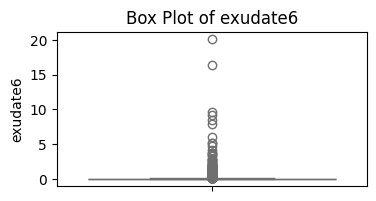

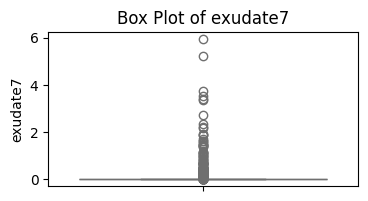

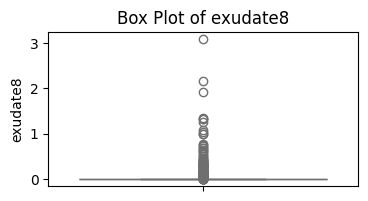

In [6]:
# Box Plot

for exudate in range(1, 9):
    column_name = f"exudate{exudate}"
    if column_name in df.columns:
        plt.figure(figsize=(4, 2))
        sns.boxplot(y=df[column_name], color='skyblue')
        plt.title(f'Box Plot of {column_name}')
        plt.ylabel(column_name)
        plt.show()
    else:
        continue  # If the column does not exist, skip to the next iteration

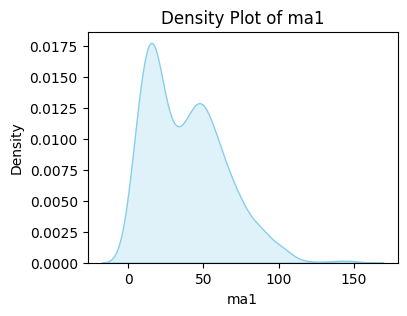

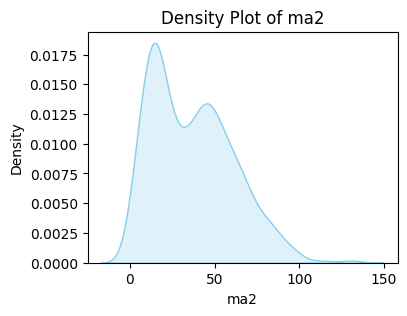

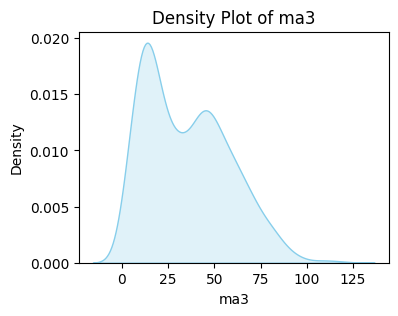

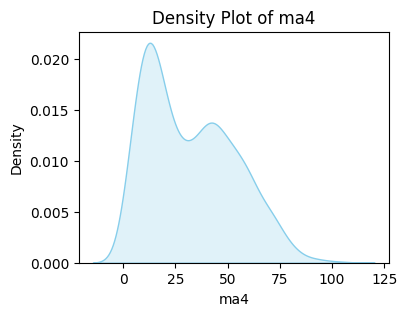

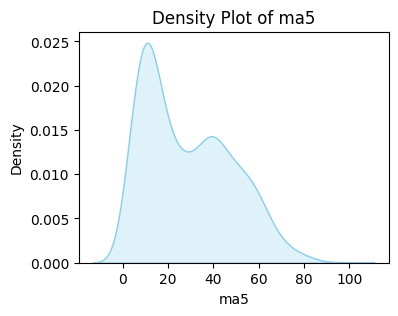

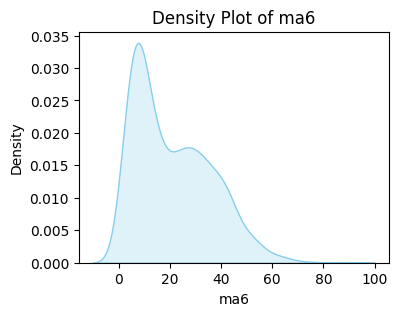

In [7]:
#  Kernel Density Estimate or KDE plot
for exudate in range(1, 9):
    column_name = f"ma{exudate}"
    if column_name in df.columns:
        plt.figure(figsize=(4, 3)) 
        sns.kdeplot(df[column_name], fill=True, color='skyblue')
        plt.title(f'Density Plot of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Density')
        plt.show()
    else:
        continue  # This column does not exist, skip to the next iteration

/tmp/ipykernel_882/2102083705.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='Blues')


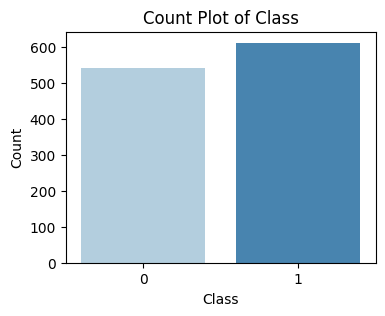

In [8]:
# Count Plot

plt.figure(figsize=(4, 3)) 
sns.countplot(x='Class', data=df, palette='Blues')
plt.title('Count Plot of Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

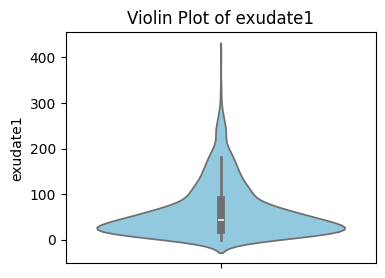

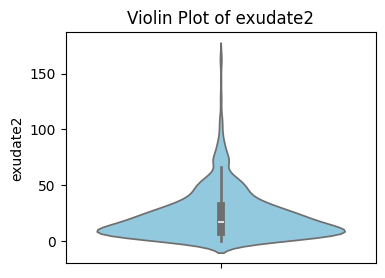

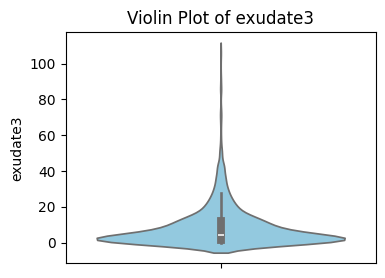

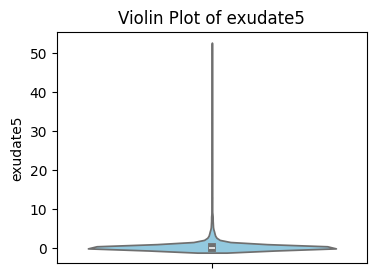

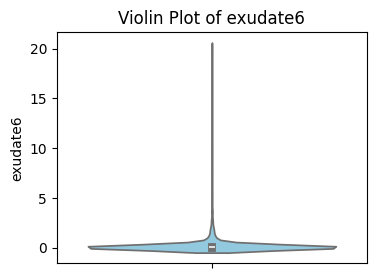

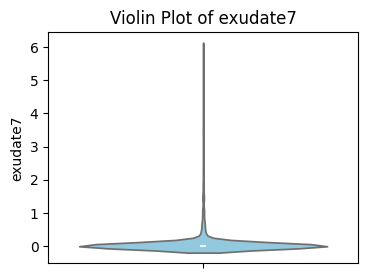

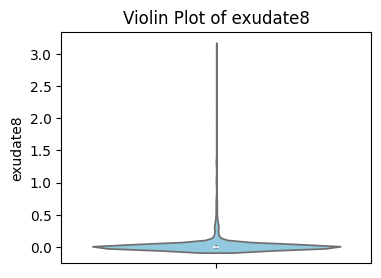

In [9]:
# Violin Plot

for exudate in range(1, 9):
    column_name = f"exudate{exudate}"
    if column_name in df.columns:
        plt.figure(figsize=(4, 3))  # Makes the plot smaller
        sns.violinplot(y=df[column_name], color='skyblue')
        plt.title(f'Violin Plot of {column_name}')
        plt.ylabel(column_name)
        plt.show()
    else:
        continue

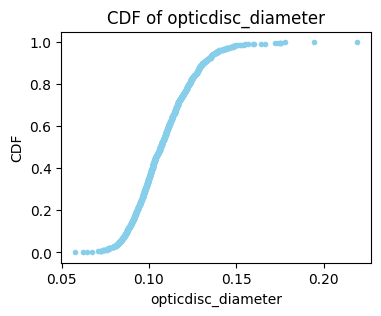

In [10]:
# Cumulative Distribution Function (CDF) of opticdisc_diameter

column_name = 'opticdisc_diameter'
if column_name in df.columns:
    plt.figure(figsize=(4, 3)) 
    
    # Sorting the data
    x = np.sort(df[column_name])
    # Calculating the cumulative distribution (y values)
    y = np.arange(1, len(x)+1) / len(x)
    
    # Creating the plot
    plt.plot(x, y, marker='.', linestyle='none', color='skyblue')
    plt.title(f'CDF of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('CDF')
    plt.show()
else:
    print(f"{column_name} not found in DataFrame.")

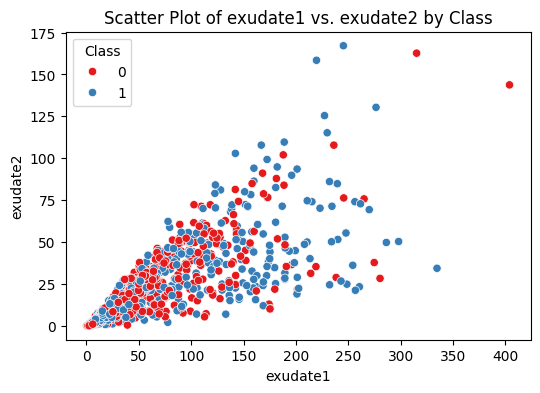

In [19]:
# Scatter Plot of exudate1 vs. exudate2 with Class as color
plt.figure(figsize=(6, 4))  
sns.scatterplot(x='exudate1', y='exudate2', hue='Class', data=df, palette='Set1')
plt.title('Scatter Plot of exudate1 vs. exudate2 by Class')
plt.xlabel('exudate1')
plt.ylabel('exudate2')
plt.legend(title='Class')
plt.show()

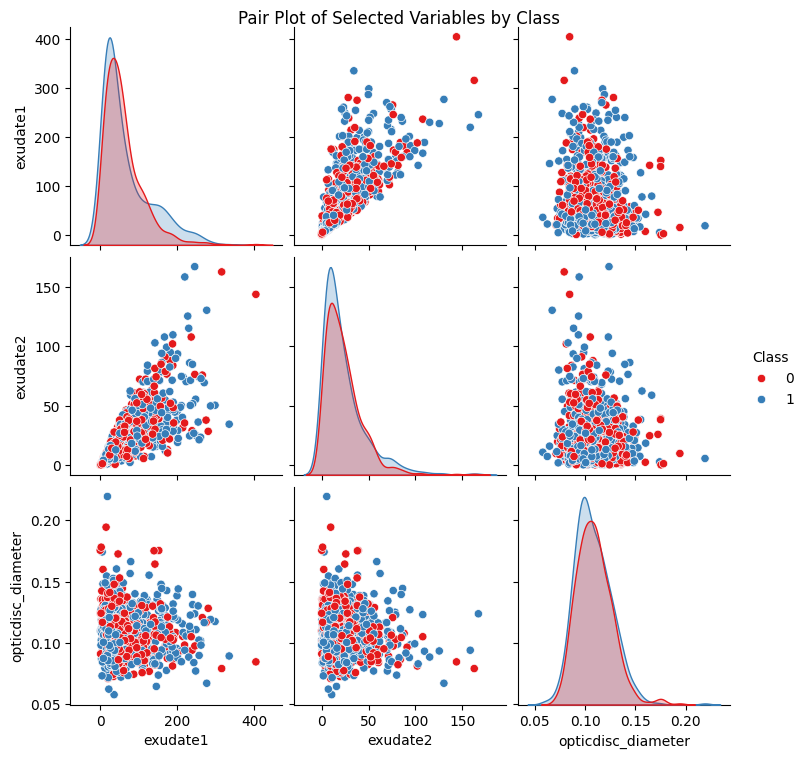

In [20]:
# Select a subset of the dataframe for the pair plot
subset_data = data[['exudate1', 'exudate2', 'opticdisc_diameter', 'Class']]

# Pair Plot for selected variables with hue for 'Class'
sns.pairplot(subset_data, hue='Class', palette='Set1', diag_kind='kde')
plt.suptitle('Pair Plot of Selected Variables by Class', verticalalignment='bottom')
plt.show()

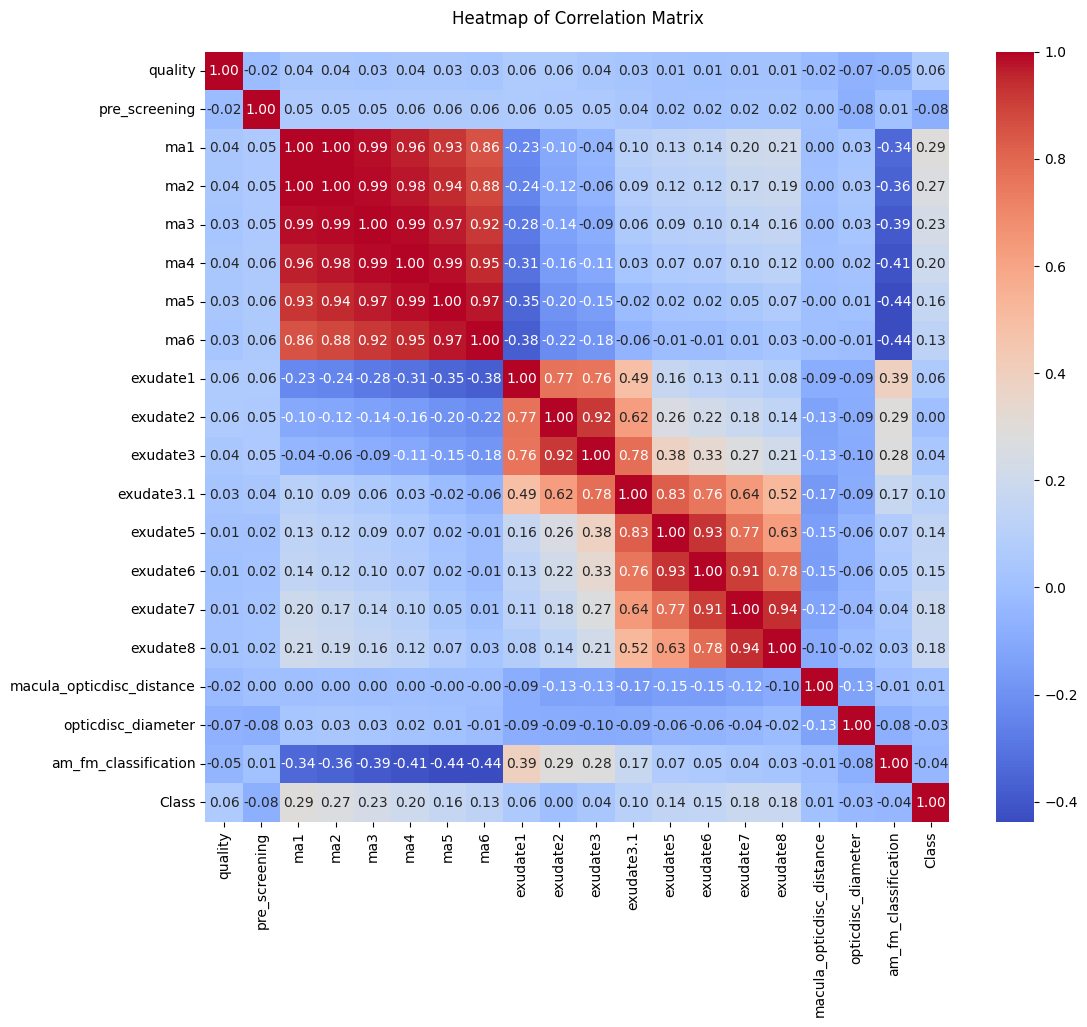

In [24]:
# Heatmap of the Correlation Matrix


# First, calculate the correlation matrix
corr_matrix = df.corr()

# Then, create the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Matrix', pad=20)  # Use 'pad' to adjust the title position if needed
plt.show()

In [11]:
# Create X & Y variables 
df = df.rename(columns={'Class': 'y'})
X = df.drop('y', axis=1)
y = df['y']

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)
X_train.describe()

,quality,pre_screening,ma1,ma2,ma3,ma4,ma5,ma6,exudate1,exudate2,exudate3,exudate3.1,exudate5,exudate6,exudate7,exudate8,macula_opticdisc_distance,opticdisc_diameter,am_fm_classification
count,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,0.996524,0.914253,37.886443,36.447277,34.734647,31.939745,28.464658,20.865585,63.177935,22.551602,8.471935,1.805922,0.556925,0.210038,0.082603,0.034041,0.523627,0.108471,0.329085
std,0.058891,0.280153,25.127629,23.693944,22.447780,20.850447,19.316171,14.847266,59.396794,21.920081,11.721881,3.996278,2.509619,1.022941,0.356737,0.149201,0.027966,0.018160,0.470153
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.349274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.367762,0.057906,0.000000
25%,1.000000,1.000000,16.000000,16.000000,15.000000,13.000000,11.000000,8.000000,21.278494,7.663805,1.192884,0.075005,0.000000,0.000000,0.000000,0.000000,0.503378,0.095868,0.000000
50%,1.000000,1.000000,36.000000,35.000000,32.000000,29.000000,25.000000,18.000000,42.769066,16.088890,4.150031,0.467823,0.019493,0.001043,0.000000,0.000000,0.523308,0.106625,0.000000
75%,1.000000,1.000000,55.000000,53.000000,51.000000,47.000000,43.000000,32.000000,82.612023,29.962393,11.237037,1.851928,0.194912,0.036899,0.004869,0.003823,0.543676,0.119809,1.000000
max,1.000000,1.000000,147.000000,132.000000,113.000000,98.000000,97.000000,89.000000,403.939108,167.131427,106.070092,59.766121,51.423208,20.098605,3.739609,1.922177,0.592217,0.219199,1.000000


In [13]:
# Model initialization and training


In [14]:
# Making predictions
predictions = model.predict(X_test)

NameError: name 'model' is not defined

In [ ]:
# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')